In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

import dyCombinedModel
from My_Jampy import JAM

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_8/Simulation_Data/"

In [2]:
#Reading inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)           #DM component
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True) #PSF
x, y, vrms, erms              = np.loadtxt("Input/vrms_data.txt", unpack=True)      #vrms data

In [3]:
#True Values of Simulation
z_l     = 0.299                                                         #Redshift of lens
z_s     = 4.100                                                         #Redshift of source
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
gamma   = 1.00                                                          #PPN parameter
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, 0.00)                                  #anisotropy [ad]
inc     = 90                                                            #inclination [deg]
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                    (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio
kappa_s = 0.075                                                         #kappa_s of DM profile
r_s     = 18.0                                                          #Scale radius [arcsec]
ml      = 7.20                                                          #mass to light ratio
phi_shear = 88                                                          #Inclination of external shear [deg]
mag_shear = 0.02                                                        #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

pixsize = 0.2    #MUSE pixel size
print("qInc: %.4f" %qinc)
print("qDM: %.4f"  %qDM)                        #MUSE pixel size

qInc: 0.5500
qDM: 0.8500


In [4]:
#Reading Image Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/image.fits",
        noise_map_path=f"{data_folder}/noise_map.fits",
        psf_path=f"{data_folder}/psf.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


#aplt.Imaging.subplot_imaging(
#    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
#)

In [5]:
#Starting Jampy Model
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)

#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [6]:
#Starting Autolens Model
#Elliptical components in Pyautolens units
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s, elliptical_comps=ell_comps, scale_radius=r_s) #elliptical NFW

mass_profile = al.mp.MGE()                            #MGE mass model
mass_profile.Analytic_Model(analytic_profile=eNFW)   #Include the analytical pENFW

#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh) #DON'T INCLUDE THE MGE PARAMETRIZATION OF DM

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [7]:
#Starting dyCombined Model

model_MGE = dyCombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile,
                                 masked_imaging=masked_image, quiet=True)
#Setup Configurations
model_MGE.mass_to_light(ml_kind='scalar')                                          #Setting scalar ML
model_MGE.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_MGE.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Dynamical")#Setting Dark matter component
model_MGE.include_DM_analytical(analytical_DM=eNFW)                                #Analytical eNFW


Change qinc limits to [0.0501, 0.55], defaults are [0.0, 1]


In [8]:
#Just Testing dyCombinedModel
#In order: ML, beta, qinc, log_mbh, kappa_s, qDM, mag_shear, phi_shear, gamma 
truth = np.array([ml, beta[0], qinc, np.log10(mbh), kappa_s, qDM, mag_shear, phi_shear, gamma])
model_MGE(truth) 

353.78872985502835

In [9]:
#In order: ML, beta, qinc, log_mbh, kappa_s, qDM, mag_shear, phi_shear, gamma 
from scipy.special import ndtri
boundary = model_MGE.boundary
def prior_transform(theta):
    """
    Flat Prior for all parameters, except for the gamma which have a gaussian prior centered in GR, i.e, 1.00
    """
    ml, beta, qinc, log_mbh, kappa_s, qDM, mag_shear, phi_shear, gamma = theta          #parameters on the unit cube
    parsDic = {"ml": ml, "beta":beta, "qinc": qinc,
                   "log_mbh":log_mbh, "kappa_s": kappa_s, "qDM":qDM,
                   "mag_shear": mag_shear, "phi_shear": phi_shear, 
                    "gamma": gamma}
    
    keys = set(parsDic.keys())                                      #All parameters
    
    #Frist the prior on gamma
    gamma_0      = 1.00       #mean
    sigma_gamma  = 0.05       #sigma/std
    
    parsDic['gamma'] = gamma_0 + sigma_gamma*ndtri(parsDic['gamma']) #Convert back to physical gamma
    excludes = set(['gamma'])  #Exclude gamma, because we already verify above
    
    for key in keys.difference(excludes): #Loop over the remains parameters
        parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
     
    return np.array(list(parsDic.values()))

def log_likelihood(pars):
    return model_MGE(pars)

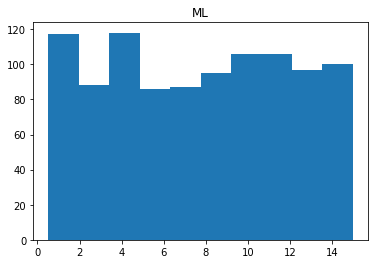

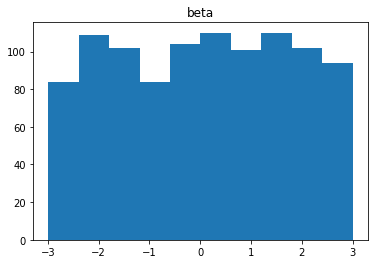

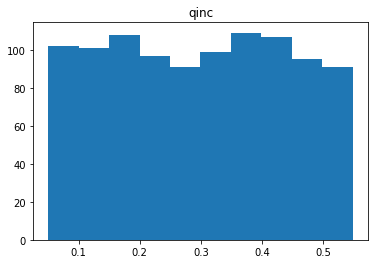

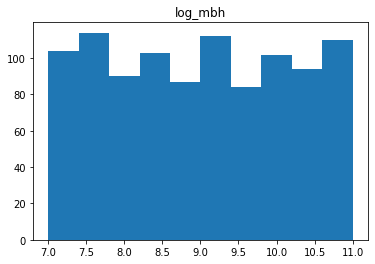

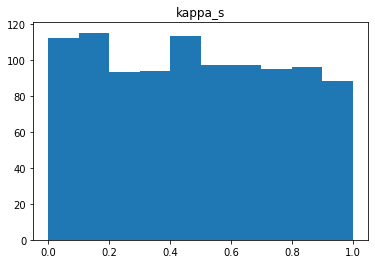

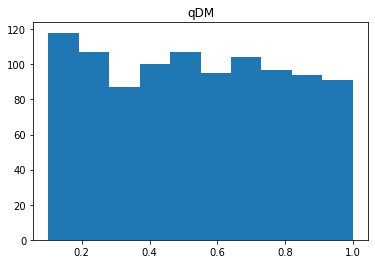

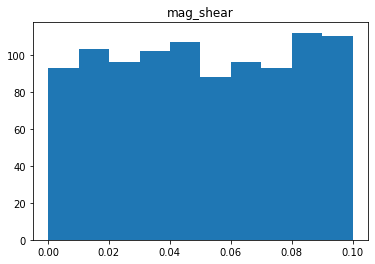

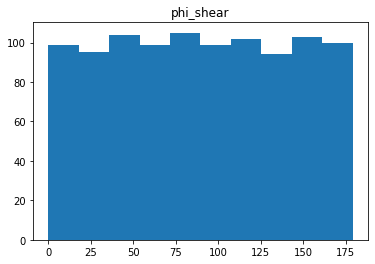

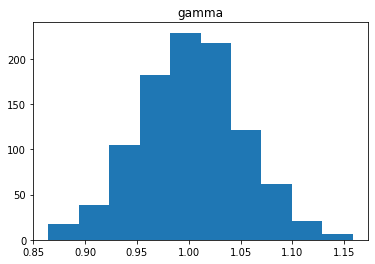

In [57]:
#Just checking the priors
import matplotlib.pyplot as plt
sample_u = np.random.rand(9, 1000)

label = ["ML", "beta", "qinc", "log_mbh", "kappa_s", "qDM", "mag_shear", "phi_shear", "gamma"]
for i in range(9):
    plt.hist(prior_transform(sample_u)[:,:][i])
    plt.title(label[i])
    plt.show()

In [10]:
#Checking the log_likelihood call
log_likelihood(truth)

353.78872985502835

In [11]:
from dynesty import NestedSampler
from multiprocessing import Pool

In [ ]:
nlive = 100              #number of (initial) live points
ndim  = truth.size       #number of dimensions



# Now run with the static sampler
sampler = NestedSampler(log_likelihood, prior_transform, ndim, pool=Pool(),queue_size=6,
                        nlive=nlive, sample="rwalk", walks=50,)

In [ ]:
sampler.run_nested(dlogz=0.01)